# Práctico 1: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar un sistema de recomendación basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
artist_data = pd.read_csv("Last_fm_data/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [5]:
user_artist_plays = pd.read_csv("Last_fm_data/user_artists.dat", sep="\t")
user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [61]:
df_analisis = pd.merge(user_artist_plays, artist_data, left_on='artistID', right_on='id')
df_analisis

,userID,artistID,weight,id,name,url,pictureURL
0,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
1,4,51,228,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
2,27,51,85,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
3,28,51,10,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
4,62,51,528,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg
...,...,...,...,...,...,...,...
92829,2100,18726,337,18726,Nyktalgia,http://www.last.fm/music/Nyktalgia,http://userserve-ak.last.fm/serve/252/49060167...
92830,2100,18727,297,18727,Atsakau niekadA,http://www.last.fm/music/Atsakau++niekadA,http://userserve-ak.last.fm/serve/252/29862435...
92831,2100,18728,281,18728,Domantas Razauskas,http://www.last.fm/music/Domantas+Razauskas,http://userserve-ak.last.fm/serve/252/165556.jpg
92832,2100,18729,280,18729,Atalyja,http://www.last.fm/music/Atalyja,http://userserve-ak.last.fm/serve/252/98093.jpg


In [62]:
df_analisis.describe()

,userID,artistID,weight,id
count,92834.000000,92834.000000,92834.00000,92834.000000
mean,1037.010481,3331.123145,745.24393,3331.123145
std,610.870436,4383.590502,3751.32208,4383.590502
min,2.000000,1.000000,1.00000,1.000000
25%,502.000000,436.000000,107.00000,436.000000
50%,1029.000000,1246.000000,260.00000,1246.000000
75%,1568.000000,4350.000000,614.00000,4350.000000
max,2100.000000,18745.000000,352698.00000,18745.000000


### Normalización de los Pesos

Se normalizan los pesos, ya que va a permitir tener mejor la relación de tiempo escucha de cada usuario con los artistas escuchados

In [84]:
#Total de Peso por User

df_analisis_tot = df_analisis[['userID','weight']].groupby(['userID']).sum()
df_analisis_tot = df_analisis_tot.reset_index()
df_analisis_tot = df_analisis_tot.rename(columns={'weight':'tot_weight'})
df_analisis_tot.head()

,userID,tot_weight
0,2,168737
1,3,20501
2,4,26930
3,5,13159
4,6,1011


In [86]:
df_analisis_norm = pd.merge(df_analisis,df_analisis_tot,how='inner',on=['userID'])
df_analisis_norm['norm_weight'] = df_analisis_norm['weight']/df_analisis_norm['tot_weight']
df_analisis_norm.head()

,userID,artistID,weight,id,name,url,pictureURL,tot_weight,norm_weight
0,2,51,13883,51,Duran Duran,http://www.last.fm/music/Duran+Duran,http://userserve-ak.last.fm/serve/252/155668.jpg,168737,0.082276
1,2,52,11690,52,Morcheeba,http://www.last.fm/music/Morcheeba,http://userserve-ak.last.fm/serve/252/46005111...,168737,0.069279
2,2,53,11351,53,Air,http://www.last.fm/music/Air,http://userserve-ak.last.fm/serve/252/251119.jpg,168737,0.067270
3,2,54,10300,54,Hooverphonic,http://www.last.fm/music/Hooverphonic,http://userserve-ak.last.fm/serve/252/40553471...,168737,0.061042
4,2,55,8983,55,Kylie Minogue,http://www.last.fm/music/Kylie+Minogue,http://userserve-ak.last.fm/serve/252/12740835...,168737,0.053237


- Distribución del total de listens por user

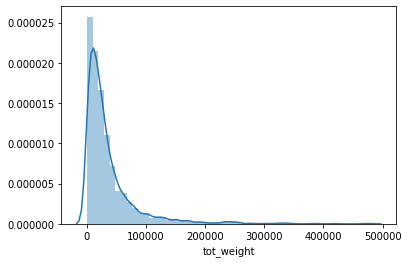

In [88]:
dist_list_x_user = df_analisis_tot[['userID','tot_weight']]
dist_list_x_user

sns.distplot(dist_list_x_user.tot_weight)

Artistas mas escuchados:

In [10]:
df_top10_artist = df_analisis.groupby(['artistID','name']).sum()[['weight']].sort_values(by=['weight'], ascending=False)
df_top10_artist.head(10)

,,weight
artistID,name,
289,Britney Spears,2393140
72,Depeche Mode,1301308
89,Lady Gaga,1291387
292,Christina Aguilera,1058405
498,Paramore,963449
67,Madonna,921198
288,Rihanna,905423
701,Shakira,688529
227,The Beatles,662116


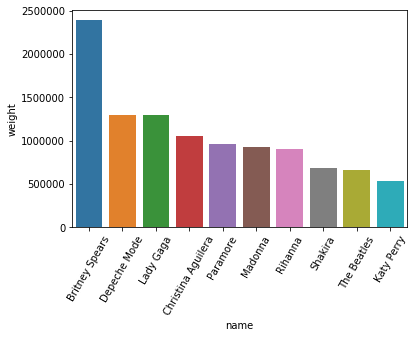

In [20]:
top10_artist_plot = df_top10_artist.head(10).reset_index().drop(columns=['artistID'])

sns.barplot(x="name", y="weight", data=top10_artist_plot)
plt.xticks(rotation=60)
plt.show()

Cantidad de listens por user

In [29]:
df_listen_user = df_analisis.groupby(['userID']).mean()[['weight']].sort_values(by=['weight'], ascending=False)
df_listen_user.head(10)

,weight
userID,
1307,34328.000000
542,19033.714286
757,9600.780000
2000,9368.180000
1418,8326.980000
1642,7765.020000
1094,7582.500000
1942,6970.540000
2071,6768.000000


Generos mas escuchados

In [33]:
generos_list = pd.read_csv("Last_fm_data/tags.dat", sep="\t", encoding='latin-1')
generos_list.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [35]:
generos = pd.read_csv("Last_fm_data//user_taggedartists.dat", sep="\t")
generos.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [36]:
df_generos_analisis = pd.merge(generos,generos_list)
df_generos_analisis

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,63,13,1,4,2009,chillout
2,2,73,13,1,4,2009,chillout
3,2,94,13,1,4,2009,chillout
4,2,6177,13,1,5,2009,chillout
...,...,...,...,...,...,...,...
186474,2096,1124,6027,1,8,2010,20th century classical
186475,2096,7932,12645,6,5,2011,symbiosis
186476,2096,8438,12645,1,8,2010,symbiosis
186477,2096,13890,12645,1,9,2010,symbiosis


In [37]:
df_generos_analisis.groupby(['tagID','tagValue']).count().sort_values(by=['userID'], ascending=False)

,,userID,artistID,day,month,year
tagID,tagValue,,,,,
73,rock,7503,7503,7503,7503,7503
24,pop,5418,5418,5418,5418,5418
79,alternative,5251,5251,5251,5251,5251
18,electronic,4672,4672,4672,4672,4672
81,indie,4458,4458,4458,4458,4458
...,...,...,...,...,...,...
7452,finding your way,1,1,1,1,1
7451,divorce,1,1,1,1,1
7450,soulmate,1,1,1,1,1


## Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [90]:
import pandas as pd

from surprise import Dataset, Reader, KNNWithMeans
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split

In [91]:
matriz = df_analisis[['userID','artistID','weight']]
matriz

,userID,artistID,weight
0,2,51,13883
1,4,51,228
2,27,51,85
3,28,51,10
4,62,51,528
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [92]:
#reader = Reader(matriz_scale=(matriz.weight.min(), matriz.weight.max()))
reader = Reader(rating_scale=(matriz.weight.min(), matriz.weight.max()))

matriz = Dataset.load_from_df(matriz[["userID", "artistID", "weight"]], reader)

In [93]:
matriz

## Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [59]:
matriz_train, matriz_test = train_test_split(matriz, test_size=0.3)
model = KNNWithMeans(k=20).fit(matriz_train)
predictions = model.test(matriz_test)
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 3451.1002


In [60]:
model = KNNWithMeans(k=5, verbose=False)
cross_validated_metrics = cross_validate(model, matriz, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    4561.09134266.12173735.07735345.34924439.78994469.4859520.9843
MAE (testset)     806.8767846.5729807.0838875.8144821.6206831.593726.4234 
Fit time          0.96    1.03    1.01    1.08    1.03    1.02    0.04    
Test time         2.65    2.19    2.23    2.37    2.72    2.43    0.21    


## NORMALIZADO Ejercicio 2 - Matriz de Usuario-Contenido

En este ejercicio, a partir del conjunto de datos, deberán generar una matriz de usuario-contenido. Tengan en cuenta que los ratings, en este caso, son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a cierto artista.

In [104]:
matriz_norm = df_analisis_norm[['userID','artistID','norm_weight']]
matriz_norm

,userID,artistID,norm_weight
0,2,51,0.082276
1,2,52,0.069279
2,2,53,0.067270
3,2,54,0.061042
4,2,55,0.053237
...,...,...,...
92829,1893,17465,0.250000
92830,1893,17466,0.250000
92831,1893,17467,0.250000
92832,1893,17468,0.250000


In [105]:
#reader = Reader(matriz_scale=(matriz.weight.min(), matriz.weight.max()))
reader_norm = Reader(rating_scale=(matriz_norm.norm_weight.min(), matriz_norm.norm_weight.max()))

matriz_norm = Dataset.load_from_df(matriz_norm[["userID", "artistID", "norm_weight"]], reader_norm)

In [106]:
matriz_norm

## NORMALIZADO Ejercicio 3 - Entrenamiento del algoritmo de recomendación

Utilizando las herramientas brindadas por Surpr!se, entrenen varios modelos de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo.

Si necesitan inspiración, les recomiendo revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).

In [107]:
norm_matriz_train, norm_matriz_test = train_test_split(matriz_norm, test_size=0.3)
norm_model = KNNWithMeans(k=20).fit(norm_matriz_train)
norm_predictions = norm_model.test(norm_matriz_test)
print("RMSE on test: {:.4f}".format(rmse(norm_predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0366


In [108]:
norm_model = KNNWithMeans(k=5, verbose=False)
norm_cross_validated_metrics = cross_validate(norm_model, matriz_norm, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0413  0.0391  0.0403  0.0390  0.0426  0.0404  0.0014  
MAE (testset)     0.0170  0.0170  0.0170  0.0169  0.0175  0.0171  0.0002  
Fit time          0.57    0.59    0.58    0.59    0.59    0.59    0.01    
Test time         1.30    1.35    1.32    1.31    1.28    1.31    0.02    


In [110]:
matriz_norm

## Ejercicio 4 - Sistema de recomendación

A partir del mejor modelo de recomendación que hayan sugerido en el caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares.

La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

- Artist Map

In [133]:
artist_data_map = artist_data[['id','name']].rename(columns={'id':'artistID'})
artist_data_map.head()

,artistID,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [113]:
_df_recsys = df_analisis_norm[['userID','artistID','norm_weight']]
_df_recsys.head()

,userID,artistID,norm_weight
0,2,51,0.082276
1,2,52,0.069279
2,2,53,0.067270
3,2,54,0.061042
4,2,55,0.053237


- Armado de Mapas para recomendación

In [120]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userID'].nunique()
    N = df['artistID'].nunique()

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M))))
    artist_mapper = dict(zip(np.unique(df["artistID"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"])))
    artist_inv_mapper = dict(zip(list(range(N)), np.unique(df["artistID"])))
    
    user_index = [user_mapper[i] for i in df['userID']]
    item_index = [artist_mapper[i] for i in df['artistID']]

    X = csr_matrix((df["norm_weight"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper

X, user_mapper, artist_mapper, user_inv_mapper, artist_inv_mapper = create_X(_df_recsys)

- Sistema de Recomendación

In [139]:
from sklearn.neighbors import NearestNeighbors

def find_similar_artists(artist_id, X, artist_mapper, artist_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    artist_ind = artist_mapper[artist_id]
    artist_vec = X[artist_ind]
    if isinstance(artist_vec, (np.ndarray)):
        artist_vec = artist_vec.reshape(1,-1)
    # use k+1 since kNN output includes the artistID of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(artist_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(artist_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [141]:
#Se define K=20 por que fue el modelo que en el ejercicio anterior nos dió RSME más bajo
artistas_a_recomendar = find_similar_artists(289, X, artist_mapper, artist_inv_mapper, k=20)
artistas_a_recomendar

[318,
 349,
 523,
 16070,
 16072,
 16073,
 16069,
 16071,
 306,
 466,
 10330,
 10329,
 293,
 1580,
 292,
 299,
 288,
 55,
 300]

- Armado de Función que asocia los IDS recomendados con los Nombres de los artistas para el usuario

In [157]:
artist_titles = dict(zip(artist_data_map['artistID'], artist_data_map['name']))

artist_id = 227

similar_artists = find_similar_artists(artist_id, X, artist_mapper, artist_inv_mapper, k=20)
artist_title = artist_titles[artist_id]

print(f"Por que escuchaste {artist_title}, te recomendamos escuchar:")
for i in similar_artists:
    print(artist_titles[i])

Por que escuchaste The Beatles, te recomendamos escuchar:
John Lennon
Paul McCartney
Onision
The J. Geils Band
Leonel García
Nicho Hinojosa
Santo & Johnny
Leon Polar
Los Shakers
George Harrison
Paul McCartney & Wings
Selena
Ringo Starr
Bob Dylan
Simon & Garfunkel
The Puppini Sisters
The Who
The Rolling Stones
Wings


In [150]:
dict_base = {'Artista Input':[], 'Recomendados':[]}
df_final = pd.DataFrame(dict_base)
df_final

,Artista Input,Recomendados
